### Evaluation - Feature Selection und Modelling

In [7]:
import sys
sys.path = ["", ".."] + sys.path[1:]

In [8]:
import pathlib
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

import numpy as np
import aisfeel

/home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


##### Der Pfad für das Verzeichnis muss unten auf den parent Ordner, in dem Datensatz liegt angepasst werden 

In [9]:
data = pathlib.Path("/space/user/hdreesmann/")
aisdk_home = data / "aisdk"
cargo_tanker_features = aisdk_home / "cargo_tanker_weather_dataset"

In [4]:
cluster = LocalCluster(n_workers=26, 
                       threads_per_worker=2,
                       memory_limit='32GB')
cluster

LocalCluster(81cc4d39, 'tcp://127.0.0.1:42591', workers=26, threads=52, memory=832.00 GB)

In [5]:
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:42591' processes=26 threads=52, memory=832.00 GB>

In [6]:
# cluster.close()

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [8]:
df = dd.read_parquet(cargo_tanker_features).drop(['type_of_mobile','eta',"latitude","longitude"],axis=1)

In [9]:
def weather_to_mag_and_dir(df):
    def magnitude(u, v):
        return (np.pi/180)*np.sqrt((np.square(u)+np.square(v)))
        
    def direction(u, v):
        return 180 + (180/np.pi*np.arctan2(u,v))
        
    current_u, current_v = df['eastward_sea_water_velocity_unit_m_s-1'], df['northward_sea_water_velocity_unit_m_s-1']
    wind_u, wind_v=  df['eastward_wind_unit_m_s-1'], df['northward_wind_unit_m_s-1']
    df["wind_magnitude"] = magnitude(wind_u,wind_v)
    df["wind_direction"] = direction(wind_u,wind_v)
    df["current_magnitude"] = magnitude(current_u, current_v)
    df["current_direction"] = direction(current_u,current_v)
    return df

def total_wave_period(df):
    df["total_wave_period"] = df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_wind_wave_mean_period_unit_s"]
    return df

def outlier_filter(df):
    zscores = ""
    threshold = 5
    filtered = -threshold < zscores < threshold
    return df[filtered]

In [10]:
df = df.pipe(weather_to_mag_and_dir).pipe(total_wave_period)

In [11]:
abebe = df.query("(sog >=5) & (`navigational_status_Under way using engine`==1)")

In [12]:
# abebe.columns

In [13]:
# len(df) - len(abebe)

In [14]:
mmsi_counts = df.mmsi.value_counts().compute()

In [15]:
top = mmsi_counts.head(10).reset_index()["index"]
top

0     211141000
1     277560000
2     257653000
3     265411000
4     231794000
5     231613000
6     244645000
7     209525000
8     257723000
9     231670000
10    375103000
11    244820422
12    209536000
13    265610040
14    230351000
15    220223000
16    357562000
17    231843000
18    257787000
19    210008000
Name: index, dtype: int64

In [16]:
abebe = abebe[abebe.mmsi.isin(top)]
df = df[df.mmsi.isin(top)]

In [17]:
len(df)

2924126

In [18]:
len(abebe)

2533017

In [19]:
# Missing: Gross tonnage, Pressure MSL, Sea surface salitnity
abebe_features = ["wind_magnitude","wind_direction","current_magnitude","current_direction","sea_water_potential_temperature_unit_degrees_c","cog","sea_surface_wave_significant_height_unit_m", "sea_surface_wave_from_direction_unit_degree","total_wave_period","sog","draught"]
abebe_data = abebe[abebe_features]
# u_ship etc. are derived from sog, so can be used to directly compute sog. exclude those
exclude = ['u_ship', 'v_ship', 'vx', 'vy', 'sog',"timestamp","mmsi"]
#X_0 is the dataset with features from abebe, X_1 includes all features to be run through selection algorithm
X_0, y = abebe_data.drop("sog",axis=1).compute(), abebe_data.sog.compute() 
X_1,y = df.drop(columns=exclude).compute(), df.sog.compute() 


In [20]:
cluster.close()

In [21]:
abebe_dtr_hyperparameters = {"min_samples_split":2,"min_samples_leaf":1, "max_features":6,"max_depth":60}


DTR_NULL = DecisionTreeRegressor(**abebe_dtr_hyperparameters)
DTR_ONE = DecisionTreeRegressor(**abebe_dtr_hyperparameters)


# efs = EFS(ETR_NULL, 
#           min_features=8,
#           max_features=10,
#          # scoring='neg_mean_squared_error',
#           cv=5,
#         print_progress=True,
# )

In [22]:
sfs = SFS(DTR_ONE, 
          k_features=(5,15), 
          forward=False, 
          floating=False, 
#           scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=58,
#           pre_dispatch='None'
         )

In [23]:
import joblib
import time

# with joblib.parallel_backend('dask'):
print(f"Beginning training")
start = time.time()
sfs.fit(X_1, y)
print(f"training took {time.time()-start} seconds")

Beginning training


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


training took 13624.795548200607 seconds


/home/hdreesmann/.cache/pypoetry/virtualenvs/aisfeel-SSR1RHrp-py3.8/lib/python3.8/site-packages/mlxtend/feature_selection/sequential_feature_selector.py:642: RuntimeWarning: Mean of empty slice
  all_avg_scores.append(np.nanmean(cv_scores))


In [10]:
# Abgespeichertes Modell laden
# import joblib

# sfs = joblib.load(data / "sbs_DTR_model_5_15.joblib")

In [11]:
print('Selected features:', sfs.k_feature_idx_)


Selected features: (4, 5, 11, 14, 17, 29, 30, 36, 39, 41, 46, 50, 56, 59, 67)


In [12]:
scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
scores.sort_values('avg_score', inplace=True, ascending=False)
scores

feature_idx  \
15  (4, 5, 11, 14, 17, 29, 30, 36, 39, 41, 46, 50,...   
23  (4, 5, 10, 11, 14, 17, 22, 29, 30, 33, 34, 36,...   
53  (3, 4, 5, 9, 10, 11, 13, 14, 16, 17, 18, 20, 2...   
22  (4, 5, 10, 11, 14, 17, 22, 29, 30, 34, 36, 39,...   
13  (4, 5, 11, 14, 17, 29, 36, 39, 41, 46, 50, 56,...   
..                                                ...   
58  (0, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 16, 17,...   
68  (0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
70  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
72  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
5                                 (4, 11, 41, 46, 50)   

                                            cv_scores avg_score  \
15  [0.5214632166162882, 0.8519683083583491, 0.416...   0.62964   
23  [0.5371862661347475, 0.7734479951968278, 0.421...   0.61529   
53  [0.46459849813206655, 0.7993226853706735, 0.51...  0.613789   
22  [0.548094400679525, 0.7179370621388603, 0.3700...  0.610529   
13  [0.6864561186532452, 0.5720452010319361, 0.420...  0.590823   
..                                                ...       ...   
58  [0.6298933614387161, 0.3742825624914441, 0.480...  0.454109   
68  [0.5671447540808172, 0.44290950064590395, -0.1...  0.436008   
70  [0.564445495252279, 0.39879364021411867, -0.18...  0.419637   
72  [0.41951723087123327, -0.03104044389039573, -0...  0.139929   
5                           [nan, nan, nan, nan, nan]       NaN   

                                        feature_names  ci_bound   std_dev  \
15  (length, draught, surface_downward_eastward_st...  0.193579  0.150611   
23  (length, draught, h3_res_5, surface_downward_e...  0.161272  0.125475   
53  (width, length, draught, d, h3_res_5, surface_...  0.169649  0.131993   
22  (length, draught, h3_res_5, surface_downward_e...  0.174975  0.136136   
13  (length, draught, surface_downward_eastward_st...  0.129145  0.100479   
..                                                ...       ...       ...   
58  (rot, width, length, draught, c, d, h3_res_5, ...  0.175789   0.13677   
68  (rot, width, length, draught, a, b, c, d, h3_r...  0.423554  0.329539   
70  (rot, heading, width, length, draught, a, b, c...  0.411197  0.319925   
72  (rot, cog, heading, width, length, draught, a,...  0.497035   0.38671   
5   (length, surface_downward_eastward_stress_unit...       NaN       NaN   

     std_err  
15  0.075305  
23  0.062737  
53  0.065996  
22  0.068068  
13  0.050239  
..       ...  
58  0.068385  
68   0.16477  
70  0.159963  
72  0.193355  
5        NaN  

[68 rows x 7 columns]

In [29]:
sfs.named_estimators

[('decisiontreeregressor',
  DecisionTreeRegressor(max_depth=60, max_features=6))]

Text(0, 0.5, 'Performance')

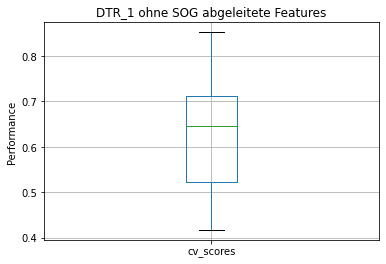

In [27]:
boxplot=scores.iloc[0].to_frame().T.cv_scores.explode().to_frame().plot(kind="box")
boxplot.set_title("DTR_1 ohne SOG abgeleitete Features")
boxplot.grid()
boxplot.set_ylabel("Performance")

In [13]:
f"best score {sfs.k_score_}"

'best score 0.6296395442547456'

In [14]:
sfs.k_feature_names_

('length',
 'draught',
 'surface_downward_eastward_stress_unit_pa',
 'eastward_wind_unit_m_s-1',
 'flag_-_0:ocean_-_1:earth/ice_unit_1',
 'sea_surface_secondary_swell_wave_mean_period_unit_s',
 'sea_surface_wave_stokes_drift_x_velocity_unit_m_s-1',
 'northward_sea_water_velocity_unit_m_s-1',
 'sea_surface_height_above_geoid_unit_m',
 'ship_type_Tanker',
 'cargo_type_Reserved for future use',
 'navigational_status_Not under command',
 'navigational_status_Reserved for future use [13]',
 'is_sailing',
 'wind_magnitude')

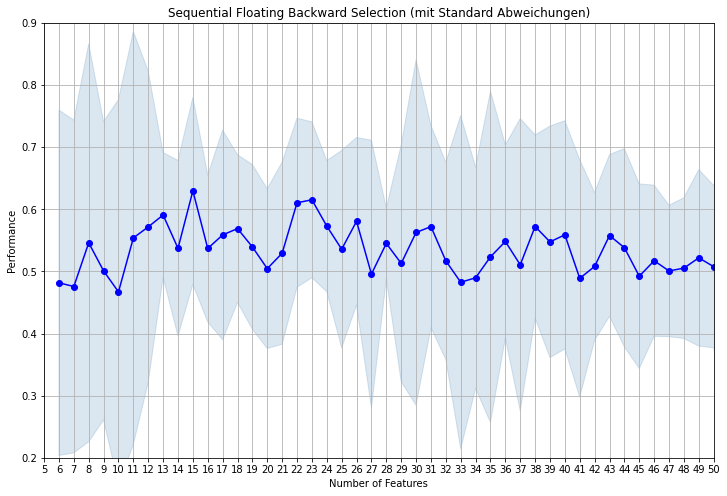

In [24]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(12, 8))

plt.ylim([0.2, 0.9])
plt.xlim([5,50])
plt.title('Sequential Floating Backward Selection (mit Standard Abweichungen)')
plt.grid()
plt.show()

In [29]:
print('Best accuracy score: %.2f' % sfs.k_score_)
print('Best subset (indices):', sfs.k_feature_idx_)
print('Best subset (corresponding names):', sfs.k_feature_names_)

Best accuracy score: 0.63
Best subset (indices): (4, 5, 11, 14, 17, 29, 30, 36, 39, 41, 46, 50, 56, 59, 67)
Best subset (corresponding names): ('length', 'draught', 'surface_downward_eastward_stress_unit_pa', 'eastward_wind_unit_m_s-1', 'flag_-_0:ocean_-_1:earth/ice_unit_1', 'sea_surface_secondary_swell_wave_mean_period_unit_s', 'sea_surface_wave_stokes_drift_x_velocity_unit_m_s-1', 'northward_sea_water_velocity_unit_m_s-1', 'sea_surface_height_above_geoid_unit_m', 'ship_type_Tanker', 'cargo_type_Reserved for future use', 'navigational_status_Not under command', 'navigational_status_Reserved for future use [13]', 'is_sailing', 'wind_magnitude')


Now using the best feature subset to train the model

In [30]:
# selected_features = sfs.transform(X_1)

In [31]:
# "Training start"
# start = time.time()
# model = DTR_ONE.fit(selected_features, y)
# f"training end {time.time() -start}"

'training end 11.835406303405762'

In [34]:
# explainer = shap.Explainer(model)
# shap_values = explainer(selected_features)

In [35]:
joblib.dump(LR_ONE, data/"DTR_model_5_15.joblib")
joblib.dump(sfs, data/"sbs_DTR_model_5_15.joblib")

['/space/user/hdreesmann/sbs_DTR_model_5_15.joblib']